In [106]:
!pip install transformers
import torch
import torch.nn as nn
import transformers
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")

SEED = 30255
MODEL_NAME = 'bert-base-uncased'
np.random.seed(SEED)
torch.manual_seed(SEED)
if USE_CUDA:
    torch.cuda.manual_seed(SEED)

COLAB = True

if COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    PATH = "gdrive/MyDrive/NLP Project/"
else:
  PATH = ""


Using cuda.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [108]:
tweets1 = pd.read_csv(PATH + "data/tweet_eval_clean.csv")

In [109]:
tweets1.head()

,Unnamed: 0,text,label,text_clean
0,0,Dark Souls 3 April Launch Date Confirmed With ...,1,dark souls april launch date confirmed with ne...
1,1,"""National hot dog day, national tequila day, t...",2,national hot dog day national tequila day the...
2,2,When girls become bandwagon fans of the Packer...,0,when girls become bandwagon fans of the packer...
3,3,@user I may or may not have searched it up on ...,1,i may or may not have searched it up on google
4,4,Here's your starting TUESDAY MORNING Line up a...,1,here s your starting tuesday morning line up a...


In [110]:
tweets2 = pd.read_csv(PATH + "data/kaggle_clean.csv")
tweets2['label'] = np.where(tweets2.sentiment == 'negative', 0, np.where(tweets2.sentiment == 'neutral', 1, 2))

In [111]:
tweets = pd.concat([tweets1, tweets2])

In [112]:
tweets.label.value_counts()

1    38580
2    29617
0    19158
Name: label, dtype: int64

In [113]:
len(tweets)

87355

In [114]:
tweets.dropna(inplace=True, subset=['text_clean'])

In [115]:
len(tweets)

87352

In [116]:
tweets['word_counts'] = tweets.text_clean.str.split().map(len)

<Axes: >

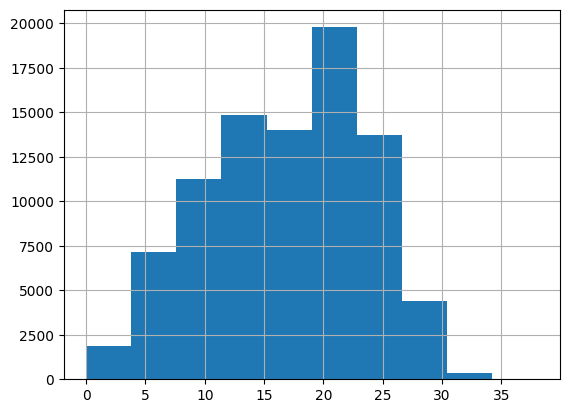

In [117]:
tweets.word_counts.hist()

In [118]:
MAX_LENGTH = 32

In [119]:
train_df , test_df  = train_test_split(tweets, test_size = 0.2, random_state = SEED, shuffle = True)
val_df , test_df  = train_test_split(test_df, test_size = 0.5, random_state = SEED, shuffle = True)

print(train_df.shape , test_df.shape , val_df.shape)

(69881, 10) (8736, 10) (8735, 10)


In [120]:
class Tweets(Dataset):
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self,idx):
        text = self.text[idx]
        encoding = self.tokenizer.encode_plus(
                          text,
                          add_special_tokens=True,
                          max_length=self.max_len,
                          truncation=True,
                          return_token_type_ids=False,
                          pad_to_max_length=True,
                          return_attention_mask=True,
                          return_tensors='pt')
        
        return {'text' : text,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'target': torch.tensor(self.target[idx], dtype = torch.long)
               }
        

In [121]:
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL_NAME)

training_data = Tweets(text = train_df.text_clean.to_numpy(),
                               target = train_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

validation_data = Tweets(text = val_df.text_clean.to_numpy(),
                               target = val_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

test_data = Tweets(text = test_df.text_clean.to_numpy(),
                               target = test_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

In [122]:
BATCH_SIZE = 64
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

In [123]:
class TweetSentimentClassifier(nn.Module):
    def __init__(self, num_classes, hid_dim, dropout=0.3):
        super(TweetSentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME, hidden_dropout_prob=0.2, attention_probs_dropout_prob=0.2)
        self.RNN = nn.RNN(self.bert.config.hidden_size, hid_dim, dropout=dropout, num_layers=2)
        self.hidden = nn.Linear(hid_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self,input_ids , attention_mask, hidden0=None):
        bert_out = self.bert(input_ids, attention_mask)[0] 
        rnn_out, hidden1 = self.RNN(bert_out, hidden0)
        dropout_out = self.dropout(rnn_out)
        hidden_out = self.hidden(dropout_out)
        final_out = nn.functional.log_softmax(hidden_out, dim=1)          
        return final_out[:, -1, :], hidden1

In [124]:
NUM_CLASSES = 3
HIDDEN_DIM = 128

model = TweetSentimentClassifier(NUM_CLASSES, HIDDEN_DIM)

if USE_CUDA:
  model = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [125]:
learning_rate = 2e-5
EPOCHS = 10
total_steps = len(train_loader) * EPOCHS

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(params = model.parameters(),lr = learning_rate, correct_bias= False)

scheduler = transformers.get_linear_schedule_with_warmup(optimizer = optimizer,
                                                        num_warmup_steps = 0,
                                                        num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [126]:
def evaluate(model, data_loader, n_examples):
    model.eval()  
    correct_pred = 0
    
    with torch.no_grad():
        hidden = None
        for batch in data_loader:
            input_ids = batch['input_id']
            attention_masks = batch['attention_mask']
            targets = batch['target']
            if USE_CUDA:
              input_ids = input_ids.cuda()
              attention_masks = attention_masks.cuda()
              targets = targets.cuda()

            output, hidden = model(input_ids, attention_masks, hidden)
            _,pred_classes = torch.max(output, dim=1)

            correct_pred += torch.sum(pred_classes==targets)
            
    return correct_pred / n_examples

In [127]:
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if h is None:
        return None
    elif isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train_model(model, data_loader, criterion, optimizer, scheduler, n_examples, train_log_interval):
    
    model.train()
    correct_pred = 0
    hidden = None
    for i, batch in enumerate(data_loader):
        input_ids = batch['input_id']
        attention_masks = batch['attention_mask']
        targets = batch['target']

        if USE_CUDA:
            input_ids = input_ids.cuda()
            attention_masks = attention_masks.cuda()
            targets = targets.cuda()
        hidden = repackage_hidden(hidden)
        output, hidden = model(input_ids , attention_masks, hidden)
        #outputs = model(input_ids , attention_masks, labels=targets)

        loss = criterion(output, targets)
        _, pred_classes = torch.max(output, dim=1)
        #loss = outputs.loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # hack to avoid gradient explotion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        correct_pred += torch.sum(pred_classes==targets)

        if (i + 1) % train_log_interval == 0:
            print(f"At iteration {i + 1} the train loss is {loss:.3f}.")
    
    return correct_pred / n_examples
   

In [128]:
TRAIN_LOG_INTERVAL = 300
MODEL_PATH = PATH + "best_sentiment_classifier_x.pt"

def run_training_loops(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_accs = []
    valid_accs = []
    best_valid_acc = 0
    
    for epoch in range(epochs):
        train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, len(train_df), TRAIN_LOG_INTERVAL)
        valid_acc = evaluate(model, val_loader, len(val_df))
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        
        print(f"After epoch {epoch+1} training accuracy is {train_acc}")
        print(f"After epoch {epoch+1} validation accuracy is {valid_acc}")
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), MODEL_PATH)
            
            
    return train_accs, valid_accs
        

        
    

In [129]:
training_accuracy, validation_accuracy = run_training_loops(model, train_loader, val_loader, loss_fn, optimizer, scheduler, EPOCHS)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


At iteration 300 the train loss is 0.645.
At iteration 600 the train loss is 0.672.
At iteration 900 the train loss is 0.581.
After epoch 1 training accuracy is 0.684649646282196
After epoch 1 validation accuracy is 0.7303949594497681
At iteration 300 the train loss is 0.545.
At iteration 600 the train loss is 0.650.
At iteration 900 the train loss is 0.385.
After epoch 2 training accuracy is 0.7568008303642273
After epoch 2 validation accuracy is 0.7337149381637573
At iteration 300 the train loss is 0.597.
At iteration 600 the train loss is 0.456.
At iteration 900 the train loss is 0.485.
After epoch 3 training accuracy is 0.7882686257362366
After epoch 3 validation accuracy is 0.7308529019355774
At iteration 300 the train loss is 0.540.
At iteration 600 the train loss is 0.486.
At iteration 900 the train loss is 0.328.
After epoch 4 training accuracy is 0.8172321319580078
After epoch 4 validation accuracy is 0.7331425547599792
At iteration 300 the train loss is 0.386.
At iteration 60

In [130]:
def get_predictions(model, data_loader):
    model = model.eval()

    tweets = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        hidden = None
        for batch in data_loader:

            texts = batch["text"]
            input_ids = batch["input_id"]
            attention_masks = batch["attention_mask"]
            targets = batch["target"]

            if USE_CUDA:
              input_ids = input_ids.cuda()
              attention_masks = attention_masks.cuda()
              targets = targets.cuda()

            outputs, hidden = model(input_ids,attention_masks, hidden)
            
            _, preds = torch.max(outputs, dim=1)

            probs = nn.functional.softmax(outputs, dim=1)

            tweets.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cuda()
    prediction_probs = torch.stack(prediction_probs).cuda()
    real_values = torch.stack(real_values).cuda()
    return tweets, predictions, prediction_probs, real_values

In [131]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [132]:
y_tweets, y_pred, y_pred_probs, y_test = get_predictions(model,test_loader)

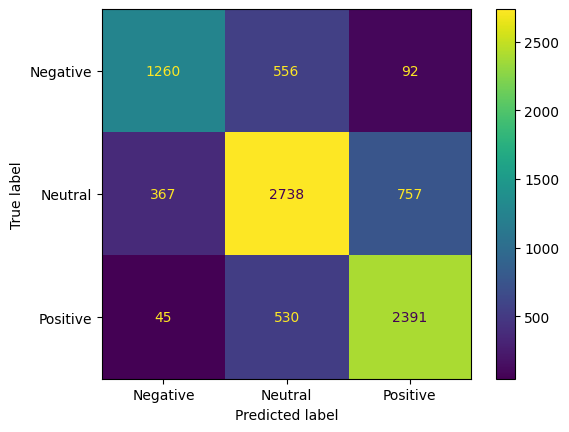

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test = y_test.cpu()
y_pred = y_pred.cpu()

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', "Positive"])
disp.plot()

In [134]:
print(f"Test Accuracy: {(y_test == y_pred).sum()/len(y_test)}")

Test Accuracy: 0.7313416004180908


In [135]:
accuarcy_df = pd.DataFrame({"training_accuarcy": [t.detach().cpu() for t in training_accuracy], })

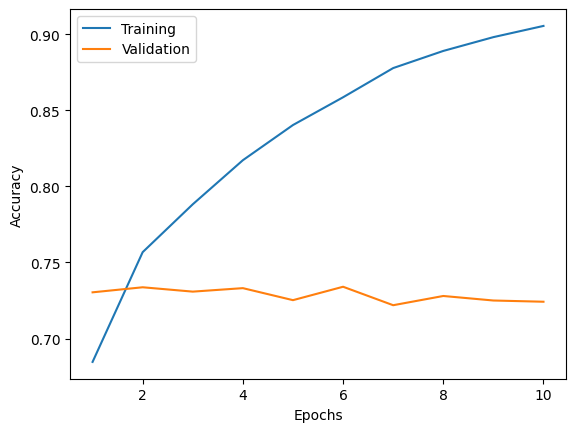

In [136]:
plt.plot(range(1, len(training_accuracy) + 1),[t.detach().cpu() for t in training_accuracy], label="Training" )
plt.plot(range(1, len(validation_accuracy) + 1),[t.detach().cpu() for t in validation_accuracy], label="Validation" )
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig(PATH + "sentiment_classifier_accuracy1.png")

In [137]:
from sklearn.metrics import precision_recall_fscore_support

In [138]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.75358852, 0.71600418, 0.73796296]),
 array([0.66037736, 0.70895909, 0.80613621]),
 array([0.70391061, 0.71246422, 0.77054463]),
 array([1908, 3862, 2966]))

In [139]:
res = torch.max(y_pred_probs, dim=1) 

In [140]:
y_pred2 = torch.where(res[0] > .75, res[1], 1) 

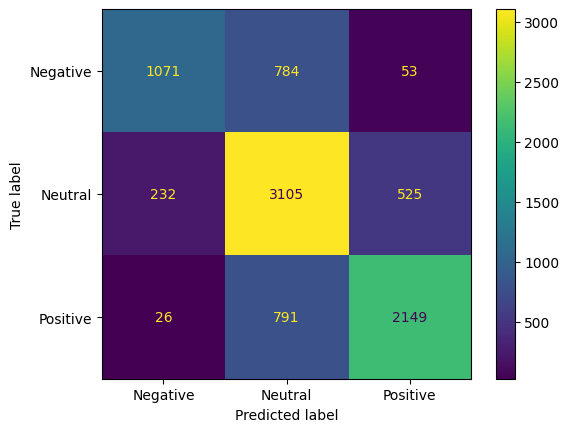

In [141]:
y_pred2 = y_pred2.cpu()
cm = confusion_matrix(y_test, y_pred2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', "Positive"])
disp.plot()

In [142]:
precision_recall_fscore_support(y_test, y_pred2)

(array([0.80586907, 0.66346154, 0.78804547]),
 array([0.56132075, 0.80398757, 0.72454484]),
 array([0.66172382, 0.72699602, 0.75496223]),
 array([1908, 3862, 2966]))

In [151]:
our_tweets = pd.read_csv(PATH + 'data/tweets_with_topics.csv', sep='\t')

In [153]:
our_tweets.head()

,Unnamed: 0.1,Unnamed: 0,edit_history_tweet_ids,author_id,created_at,conversation_id,id,text,geo.place_id,referenced_tweets,city,inside,withheld.copyright,withheld.country_codes,withheld.scope,hashtag,text_hash_split,text_clean,dominant_topic
0,0,1268,['1391443346443411457'],1267945445084598274,2021-05-09T17:22:00.000Z,1391443346443411457,1.391443e+18,Does #FortWorth ever cross your mind? \nhttps:...,NaN,NaN,Fort Worth,1.0,NaN,NaN,NaN,"['FortWorth', 'Stockyards', 'SUV', 'Limo']",Does fort worth ever cross your mind? \nhttps:...,does fort worth ever cross your mind and 469 2...,?
1,1,4672,['1311653244112957440'],5445832,2020-10-01T13:04:37.000Z,1311653244112957440,1.311653e+18,P.F.L. Always! 2004-06\n.\n.\nFollow @playarab...,42e46bc3663a4b5f,NaN,Fort Worth,1.0,NaN,NaN,NaN,"['playarabbit', 'theparksmall', 'fortworth', '...",P.F.L. Always! 2004-06\n.\n.\nFollow @playarab...,p f l always 06 follow play a rabbit the park ...,social
2,2,2327,['1423822631577456648'],41679815,2021-08-07T01:45:43.000Z,1423822631577456648,1.423823e+18,"Disabled vehicle, right lane blocked in #FortW...",42e46bc3663a4b5f,NaN,Fort Worth,1.0,NaN,NaN,NaN,"['FortWorth', 'DFWTraffic']","Disabled vehicle, right lane blocked in fort w...",disabled vehicle right lane blocked in fort wo...,transportation
3,3,66,['1287040376738635776'],347029713,2020-07-25T15:01:52.000Z,1287040376738635776,1.287040e+18,Pickup Man the Cowboy’s Cowboy🤠 #stockyardsch...,42e46bc3663a4b5f,NaN,Fort Worth,1.0,NaN,NaN,NaN,"['stockyardschampionshiprodeo', 'stockyardspro...",Pickup Man the Cowboy’s Cowboy🤠 stockyardscha...,pickup man the cowboys cowboy stockyardschampi...,music
4,4,2525,['1376576317903241217'],41679815,2021-03-29T16:45:44.000Z,1376576317903241217,1.376576e+18,Accident. two left lanes blocked. in #FortWort...,42e46bc3663a4b5f,NaN,Fort Worth,1.0,NaN,NaN,NaN,"['FortWorth', 'DFWTraffic']",Accident. two left lanes blocked. in fort wort...,accident two left lanes blocked in fort worth ...,transportation


In [155]:
our_data = Tweets(text = our_tweets.text_clean.to_numpy(),
                               target = np.zeros(len(our_tweets)),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

In [156]:
data_loader = DataLoader(our_data , batch_size = BATCH_SIZE , shuffle = False)

In [157]:
y_tweets_final, y_pred_final, y_pred_probs_final, y_test_final = get_predictions(model,data_loader)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [168]:
sentiment_class = y_pred_final.cpu().numpy()
probs = y_pred_probs_final.cpu().numpy()

In [170]:
our_tweets[['neg_prob', 'neu_prob', 'pos_prob']] = probs

In [171]:
our_tweets.head()

,Unnamed: 0.1,Unnamed: 0,edit_history_tweet_ids,author_id,created_at,conversation_id,id,text,geo.place_id,referenced_tweets,...,withheld.copyright,withheld.country_codes,withheld.scope,hashtag,text_hash_split,text_clean,dominant_topic,neg_prob,neu_prob,pos_prob
0,0,1268,['1391443346443411457'],1267945445084598274,2021-05-09T17:22:00.000Z,1391443346443411457,1.391443e+18,Does #FortWorth ever cross your mind? \nhttps:...,NaN,NaN,...,NaN,NaN,NaN,"['FortWorth', 'Stockyards', 'SUV', 'Limo']",Does fort worth ever cross your mind? \nhttps:...,does fort worth ever cross your mind and 469 2...,?,0.001040,0.904702,0.094258
1,1,4672,['1311653244112957440'],5445832,2020-10-01T13:04:37.000Z,1311653244112957440,1.311653e+18,P.F.L. Always! 2004-06\n.\n.\nFollow @playarab...,42e46bc3663a4b5f,NaN,...,NaN,NaN,NaN,"['playarabbit', 'theparksmall', 'fortworth', '...",P.F.L. Always! 2004-06\n.\n.\nFollow @playarab...,p f l always 06 follow play a rabbit the park ...,social,0.000935,0.831729,0.167336
2,2,2327,['1423822631577456648'],41679815,2021-08-07T01:45:43.000Z,1423822631577456648,1.423823e+18,"Disabled vehicle, right lane blocked in #FortW...",42e46bc3663a4b5f,NaN,...,NaN,NaN,NaN,"['FortWorth', 'DFWTraffic']","Disabled vehicle, right lane blocked in fort w...",disabled vehicle right lane blocked in fort wo...,transportation,0.028353,0.968561,0.003086
3,3,66,['1287040376738635776'],347029713,2020-07-25T15:01:52.000Z,1287040376738635776,1.287040e+18,Pickup Man the Cowboy’s Cowboy🤠 #stockyardsch...,42e46bc3663a4b5f,NaN,...,NaN,NaN,NaN,"['stockyardschampionshiprodeo', 'stockyardspro...",Pickup Man the Cowboy’s Cowboy🤠 stockyardscha...,pickup man the cowboys cowboy stockyardschampi...,music,0.001861,0.932366,0.065773
4,4,2525,['1376576317903241217'],41679815,2021-03-29T16:45:44.000Z,1376576317903241217,1.376576e+18,Accident. two left lanes blocked. in #FortWort...,42e46bc3663a4b5f,NaN,...,NaN,NaN,NaN,"['FortWorth', 'DFWTraffic']",Accident. two left lanes blocked. in fort wort...,accident two left lanes blocked in fort worth ...,transportation,0.218750,0.771273,0.009977


In [172]:
our_tweets['sentiment_numeric'] = sentiment_class

In [176]:
our_tweets['sentiment'] = np.where(our_tweets.sentiment_numeric == 0, "negative", np.where(our_tweets.sentiment_numeric == 1, 'neutral', 'positive'))

In [177]:
our_tweets.sentiment.value_counts()

neutral     15194
positive    10335
negative     1671
Name: sentiment, dtype: int64

In [178]:
our_tweets.to_csv(PATH +"data/tweets_with_topics_sentiment.csv")